Here, we illustrate a naive gradient model does not work so well, even if optimised to generate data that look visually ok.

 $x,z\sim p_\theta(z,x)$
 
The gradient model is a neural network $S_\gamma$ that takes $x$ and a random noise $\epsilon$ and outputs a "posterior sample"  $z'$ in the space of $z$, and $z'=S_\gamma(x,\epsilon)$. The gradient model is trained so that the MSE betwee $\log p_\theta(S_\gamma(x,\epsilon),x)$  and $\log p_\theta(z',x)$ are minimised over $\gamma$. We can then use $S_\gamma$ to produce a sample and evaluate $\log p_\theta(z',x)$ with $x$, and compute gradient by auto-diff, same as ALWS.

The results are not so good (high FID score), although we tried hard to make it look nice visually. We then use $S_\gamma$ 

Ideally, we would want the MSE betwee $\nabla_\theta \log p_\theta(S_\gamma(x,\epsilon),x)$  and $\nabla_\theta \log p_\theta(z',x)$ to be minimised, but this is not easily implemented. 

In [ ]:
import os
os.environ["MKL_NUM_THREADS"]="16" 
os.environ["NUMEXPR_NUM_THREADS"]='16'
os.environ["OMP_NUM_THREADS"]='16'
import matplotlib.pyplot as plt
import types
import numpy as np
from tqdm import notebook
from mmd import MMD_3_Sample_Test
import torch
from torch import optim

%matplotlib inline

from importlib import reload
import torchvision

import Generators, Features, Data, GradientEstimators

import KernelWakeSleep as kws

device = torch.device("cuda:0")
reload(Data)

In [ ]:
batch_size = 100

dname = "mnist"
binary= False and dname == "fmnist"
nc = 3 if dname in ["cifar", "celeb"] else 1


nsleep = 2000
nepoch = 20
nvalid = 200

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

train_loader, test_images = Data.load_data(dname, binary=binary, ntrain=10**5, ntest=10**4, image_size=32, batch_size=batch_size)
Dx = test_images.shape[-1]
image_size = int(np.sqrt(Dx//nc))

In [ ]:
reload(Generators)
reload(Features)
reload(Likelihoods)
reload(GradientEstimators)

In [4]:
D0 = 16
log_noise = torch.zeros((), requires_grad=True, device=device)

if dname == "van":
    tanh = sigmoid = False
else:
    tanh = not binary
    sigmoid = binary
    
ngf = 64
# generative model
prior = torch.distributions.Normal(torch.zeros(D0, device=device), torch.ones(D0,device=device))


# fully connected generator
# gen_network = Generators.fc_gen(D0,512,512,image_size**2*nc,tanh=tanh, sigmoid=False).to(device)

# convolutional generator
gen_network = Generators.dc_gen(D0,ngf, tanh=tanh, sigmoid=sigmoid, nc=nc).to(device)

if not binary:
    obs   = Likelihoods.GaussianObservation(gen_network, log_noise)
else:
    obs   = Likelihoods.BernoulliObservation(gen_network)

In [5]:
nsleep = 2000
num_post = 1
gm = GradientEstimators.ConvEstimator(image_size, nc=nc, D0=D0,bn=True).to(device)

In [6]:

optimizer = optim.Adam(list(gen_network.parameters())+[log_noise], lr=0.001)
grad_optimizer = optim.Adam(gm.parameters(), lr=0.001)


Elogps = []
losses = []

log_lams = []
log_sigmas = []

network_norms = []
kernel_network_norms = []
kernel_network_feat_norms = []
noise_stds = []
network_grad_norms = []

feat_mmds = []
recons = []

In [8]:
nsleep = 100
num_post = 1
gm.train()


for ei in notebook.tqdm(range(10)):
    
    with notebook.tqdm(train_loader, leave=False) as t:
        for i, (X_tr,) in enumerate(t):
        
            X_tr = X_tr.float().to(device)

            
            data_0, data_1, norm, nat = kws.sleep(prior, obs, nsleep)
            
            true_logp = (nat * obs.suff(data_1)).sum(-1) - norm
            
            z = gm.post_samples(data_1)

            post_logp = (obs.nat(z).reshape(nsleep,num_post,-1).mean(1) * obs.suff(data_1)).sum(-1) - \
                        obs.norm(z).reshape(nsleep,num_post).mean(1)

#             post_logp = post_elbos(data_1)[:,0]
            
            loss = ((post_logp - true_logp)**2).mean(0)
            
            grad_optimizer.zero_grad()
            loss.backward(create_graph=False)
            grad_optimizer.step()
            
            z = gm.post_samples(X_tr).detach()
                
            post_logp = -((obs.nat(z).reshape(batch_size,num_post,-1).mean(1) * obs.suff(X_tr)).sum(-1) - \
                          obs.norm(z).reshape(batch_size,num_post,-1).mean(1)).mean()
#             post_logp = post_elbos(X_tr).mean()
            optimizer.zero_grad()
            post_logp.backward()
            optimizer.step()
            

            Elogps += post_logp.item(),
            
            
#             for m in obs.network.parameters():
#                 m.detach()

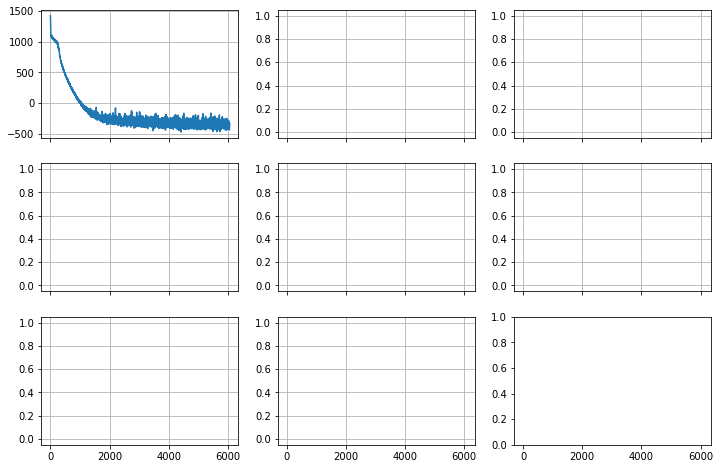

In [9]:
params = [Elogps,losses, log_sigmas, 
          log_lams, network_norms, network_grad_norms, 
          kernel_network_norms, noise_stds]

nplot = len(params)
fig, axes = plt.subplots(3,nplot//3+1, figsize=(12,8), sharex=True)
axes = np.ravel(axes)
for i in range(nplot):
    axes[i].plot(params[i])
    axes[i].grid(True)
# axes[0].set_xlim([20000,2000])

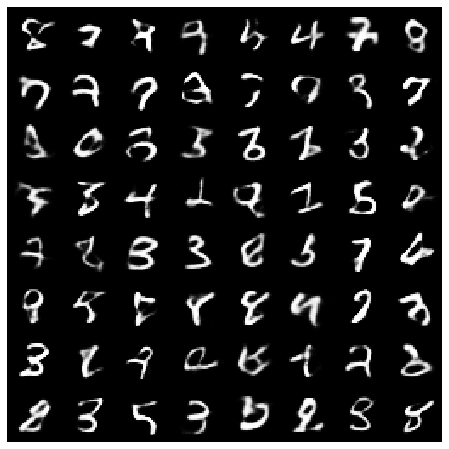

In [10]:
from scipy.stats import norm
from itertools import product
nz = 8
margin = 0.1
zgrid = norm.ppf(np.linspace(margin,1-margin,nz))

x = kws.draw_mean(prior, obs, nz*nz).detach().cpu().numpy()
x = x.reshape(x.shape[0], nc, image_size, image_size)
x = np.transpose(x, (0,2,3,1))
x = x.reshape(nz,nz,image_size,image_size,nc)

x = np.concatenate(x,-2)
x = np.concatenate(x,0)
if nc == 1:
    x = x[...,0]
plt.figure(figsize=(8,8))
if x.min() < 0:
    x = x/2. + 0.5
plt.imshow(x, cmap="gray")
plt.gca().set_axis_off()
# plt.savefig("figs/mnist_10d_after_2.pdf", bbox_inches='tight', pad_inches=0)

In [11]:
ntest= 10000
model_samples = x = kws.draw_mean(prior, obs, ntest).detach().cpu().numpy()

In [ ]:
import Metrics
reload(Metrics)
lenet = Metrics.LeNet5()

In [13]:
Metrics.FID(lenet, test_images[:ntest], (model_samples))

8.580248004271127